# of train samples : 6428
# of validation samples:  1608

Epoch 1/5
201/201 [==============================] - 71s 351ms/step - loss: 0.0202 - val_loss: 0.0074
Epoch 2/5
201/201 [==============================] - 69s 343ms/step - loss: 0.0161 - val_loss: 0.0060
Epoch 3/5
201/201 [==============================] - 80s 397ms/step - loss: 0.0148 - val_loss: 0.0061
Epoch 4/5
201/201 [==============================] - 78s 386ms/step - loss: 0.0139 - val_loss: 0.0059
Epoch 5/5
201/201 [==============================] - 77s 385ms/step - loss: 0.0130 - val_loss: 0.0060
Model was saved successfully 


dict_keys(['val_loss', 'loss'])


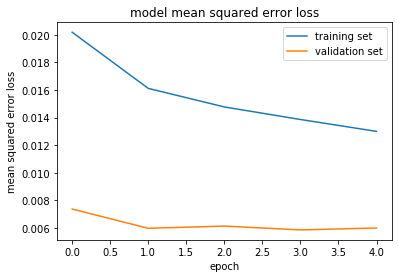

In [3]:
import os
import csv
import cv2
import math
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

lines=[]
with open("../p4_data/data/driving_log.csv") as csvfile:
    reader=csv.reader(csvfile)
    for line in reader:
        lines.append(line)


train_samples, validation_samples = train_test_split(lines, test_size=0.2)
print("# of train samples :",len(train_samples))
print("# of validation samples: ",len( validation_samples))

def generator(samples, batch_size=32,correction=0.2,crop_H=50,crop_L=140):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                for i in range(3):
                    name = '../p4_data/data/IMG/'+batch_sample[i].split('/')[-1]
                    image = cv2.cvtColor(cv2.imread(name), cv2.COLOR_BGR2RGB)
                    image = image[crop_H:crop_L, :]
                    angle = float(batch_sample[3])
                    images.append(image)
                         
                    if(i==0):
                        angles.append(angle)
                    elif(i==1):
                        angles.append(angle+correction)
                    elif(i==2):
                        angles.append(angle-correction)
                    
                    images.append(cv2.flip(image,1))
                    if(i==0):
                        angles.append(angle*-1)
                    elif(i==1):
                        angles.append((angle+correction)*-1)
                    elif(i==2):
                        angles.append((angle-correction)*-1)

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            #print("X_train.shape:", X_train.shape)
            #print("y_train.shape:", y_train.shape)
            yield sklearn.utils.shuffle(X_train, y_train)

            
# Set our batch size
batch_size=32
correction=0.2
crop_H=50
crop_L=140
ch, row, col = 3, 90, 320 

# compile and train the model using the generator function
train_generator = generator(train_samples,batch_size,correction,crop_H,crop_L)
validation_generator = generator(validation_samples,batch_size,correction,crop_H,crop_L) 

    
from keras.models import Sequential, Model
from keras.layers import Flatten, Dense,Lambda, Dropout, Conv2D, Cropping2D, BatchNormalization, Activation
from keras.layers.pooling import MaxPooling2D
import matplotlib.pyplot as plt

model=Sequential()
model.add(Lambda(lambda x: x/255 - 0.5, input_shape=(row, col,ch), output_shape=(row, col,ch)))
model.add(Conv2D(filters=24, kernel_size=5, strides=(2, 2), activation='relu'))
model.add(Conv2D(filters=36, kernel_size=5, strides=(2, 2), activation='relu'))
model.add(Conv2D(filters=48, kernel_size=5, strides=(2, 2), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=3, strides=(1, 1), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=3, strides=(1, 1), activation='relu'))
model.add(Flatten())
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))


model.compile(loss='mse',optimizer='adam')
history_object=model.fit_generator(train_generator, 
            steps_per_epoch=math.ceil(len(train_samples)/batch_size), 
            validation_data=validation_generator, 
            validation_steps=math.ceil(len(validation_samples)/batch_size), 
            epochs=5, verbose=1)

model.save('model.h5')
print("Model was saved successfully \n\n")

### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()



